In [1]:
from data import Data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

There are many ways of executing an RNN algorithm for a sequential data. In the following model, we will go with a simple method. Instead of using the data, the forward method takes an initial impulse $(1,0,\ldots,0)$, and maps it to a sequence of hidden states. This corresponds to the following:

$H_0 = \tanh(W_{xh})$

$H_t = \tanh(H_{t-1}.W_{hh})$

$O_t = \tanh(H_t W_{hr})$

The hidden states are calculated by successive application of $W_{hh}$ (+tanh). We do not use data in the model. Data will be used for calculating the loss function. This method is good at capturing periodicity of data.

In [2]:
class RNN_model(nn.Module):  
    def __init__(self, num_inputs, num_hiddens,num_out=1):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens, bias=False)
        self.linear = nn.Linear(num_hiddens, num_out, bias=False)
    def forward(self, X, H):
        X_0 = torch.zeros(len(X),1)
        X_0[0] = 1.
        state, H = self.rnn(X_0,H)
        pred = self.linear(state)
        return pred, H, state #Return state to analyze the state space

In [3]:
def rnn_train(model, X, optimizer, criterion, H, epoch):
    model.train()
    optimizer.zero_grad()
    y_hat,H, state = model(X, H)
    loss = criterion(X,y_hat) # Here, we use the data to calculate loss
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(torch.sqrt(loss.detach()))

In [4]:
data = Data(0.1,100,0.)
X = data.x.unsqueeze(-1)
mse_loss = nn.MSELoss()
rnn_model = RNN_model(1,2) #hidden state of size 2 is enough for sine
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.01)
for epoch in range(5001):
    H = torch.zeros(1,2)
    rnn_train(rnn_model, X, optimizer, mse_loss, H, epoch)

tensor(0.6898)
tensor(0.0112)
tensor(0.0027)
tensor(0.0026)
tensor(0.0027)
tensor(0.0044)


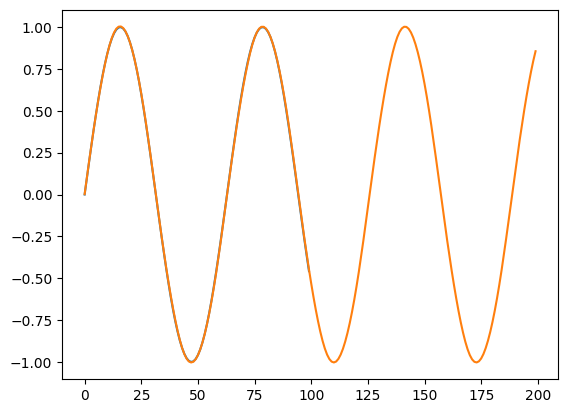

In [5]:
X_zeros = torch.zeros(200,1) 
X_rnn_pred, H_rnn_out, states = rnn_model(X_zeros,H)
X_rnn_pred = X_rnn_pred.detach()
plt.plot(X)
plt.plot(X_rnn_pred)

Looks good. As we see, our model predicts future perfectly since sinus wave is highly symmetrical. 

Next, we will analyze our model and the state space. First, let's see what parameters we have learnt:

In [6]:
params_list = list(rnn_model.parameters())
params_list = [x.detach() for x in params_list]
params_list

[tensor([[-0.2084],
         [ 0.2829]]),
 tensor([[ 1.0028,  0.1003],
         [-0.1166,  1.0627]]),
 tensor([[1.9265, 1.4452]])]

As we can see, $W_{hh}$ is an anti-symmetric matrix, just like rotation matrices. If we were not using a tanh activation function, we would have found exactly rotation matrices. 

Next, we plot state space. First, plot two state vectors independently and second, we plot them relative to each other.

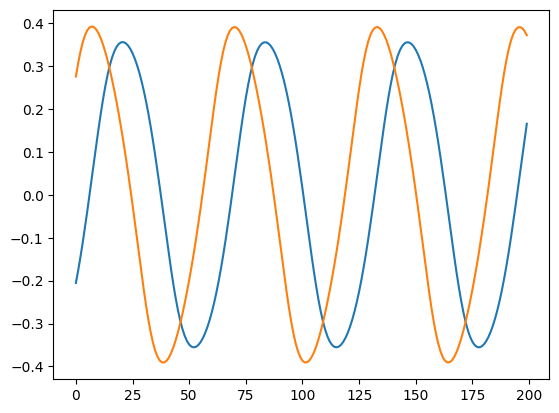

In [7]:
states = states.detach()
plt.plot(states)

Let's plot scaled states relative to each other. Result is an ellipse, resambling to a circle which is a representation of sinus in polar coordinates.
However, due to the use of the tanh activation function, the plot deviates from a perfect circle. While the activation function unnecessarily complicates the symmetry of a sine wave, it becomes beneficial in handling more complex, non-symmetric cases.

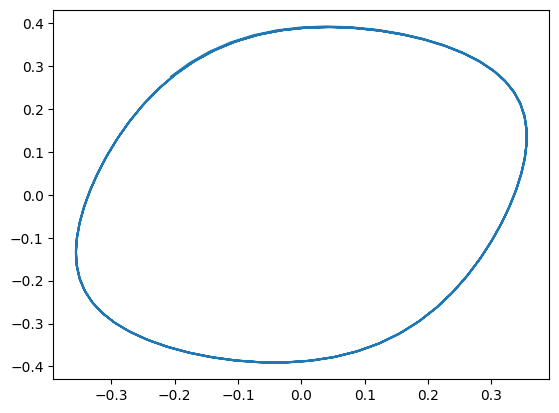

In [8]:
plt.plot(states[:,0],states[:,1])

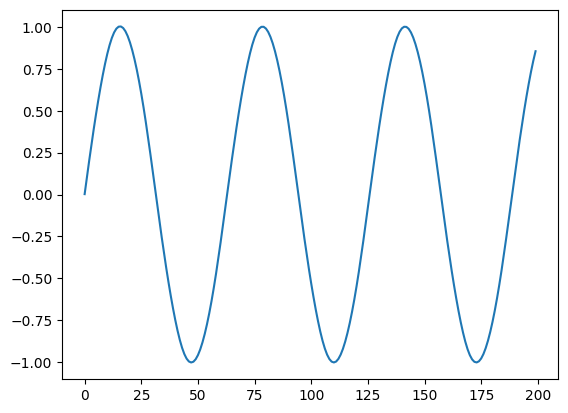

In [9]:
#And finally, we sum up the scaled states to find the sine wave.
lin_params_list=params_list[-1][0]
out = (lin_params_list[0]*states[:,0])+(lin_params_list[1]*states[:,1])
plt.plot(out)